In [ ]:
!pip install catboost -q
!pip install association-metrics -q
!pip install optuna -q

In [ ]:
import pandas as pd
import numpy as np
import association_metrics as am
import seaborn as sns
import matplotlib.pyplot as plt
from catboost import CatBoostRegressor
import optuna

In [ ]:
import warnings

warnings.filterwarnings("ignore")

In [ ]:
TRAIN = "https://raw.githubusercontent.com/evgpat/edu_stepik_practical_ml/main/datasets/chocolate_train.csv"
TEST = "https://raw.githubusercontent.com/evgpat/edu_stepik_practical_ml/main/datasets/chocolate_test_new.csv"

In [ ]:
train_df = pd.read_csv(TRAIN)

Первые шаги: анализ полученных данных

In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1255 entries, 0 to 1254
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Company               1255 non-null   object 
 1   Specific Bean Origin  1255 non-null   object 
 2   REF                   1255 non-null   int64  
 3   Review                1255 non-null   int64  
 4   Cocoa Percent         1255 non-null   object 
 5   Company Location      1255 non-null   object 
 6   Rating                1255 non-null   float64
 7   Bean Type             1254 non-null   object 
 8   Broad Bean Origin     1254 non-null   object 
dtypes: float64(1), int64(2), object(6)
memory usage: 88.4+ KB


In [ ]:
train_df.describe(include='object')

,Company,Specific Bean Origin,Cocoa Percent,Company Location,Bean Type,Broad Bean Origin
count,1255,1255,1255,1255,1254,1254
unique,376,762,40,58,38,84
top,Soma,Madagascar,70%,U.S.A.,,Venezuela
freq,35,39,461,521,628,144


Самый популярный Bean Type - "пустой"


In [ ]:
train_df.describe()

,REF,Review,Rating
count,1255.000000,1255.000000,1255.000000
mean,1045.152191,2012.382470,3.176494
std,551.284249,2.922499,0.478948
min,5.000000,2006.000000,1.000000
25%,593.000000,2010.000000,2.750000
50%,1077.000000,2013.000000,3.250000
75%,1514.000000,2015.000000,3.500000
max,1952.000000,2017.000000,5.000000


In [ ]:
train_df

,Company,Specific Bean Origin,REF,Review,Cocoa Percent,Company Location,Rating,Bean Type,Broad Bean Origin
0,Willie's Cacao,Rio Caribe,457,2009,72%,U.K.,3.25,Trinitario,Venezuela
1,Beschle (Felchlin),"Ocumare, Premier Cru, Quizas No. 2",508,2010,72%,Switzerland,3.50,,Venezuela
2,Dark Forest,Tanzania,1554,2015,70%,U.S.A.,3.00,,Tanzania
3,Brasstown aka It's Chocolate,Cooproagro,1125,2013,72%,U.S.A.,3.00,Trinitario,Dominican Republic
4,Pralus,"Java, Indonesie",32,2006,75%,France,3.50,Criollo,Indonesia
...,...,...,...,...,...,...,...,...,...
1250,Artisan du Chocolat,Madagascar,363,2009,80%,U.K.,3.00,"Criollo, Trinitario",Madagascar
1251,Marana,Cusco,1884,2016,70%,Peru,2.75,,Peru
1252,Arete,Nacional,1534,2015,68%,U.S.A.,3.50,Forastero (Nacional),Peru
1253,Fresco,"Conacado, #212, LR, SC",642,2011,72%,U.S.A.,3.50,,Dominican Republic


Проверим, что это за пустой символ, т.к. метод describe указал на наличие лишь одного пропуска в таблице

In [ ]:
train_df['Bean Type'][1]

'\xa0'

Проверим, встречается ли ещё такой "пропуск" в данных

In [ ]:
for col in train_df.columns:
  miss = (train_df[col] == '\xa0').sum()
  if miss:
    print(f'Column "{col}" has {miss} rows with "\\xa0" in it')

Column "Bean Type" has 628 rows with "\xa0" in it
Column "Broad Bean Origin" has 55 rows with "\xa0" in it


Очень много пропусков в Bean Type, почти 50%. Удалять все строки не самый разумный вариант. Но проверим далее в нескольких тестах важность признака на целевую переменную.

Сравним статистики с учётом этого пропуска и без

In [ ]:
print(train_df[train_df['Bean Type'] == '\xa0']['Rating'].describe(), '\n')
print(train_df[train_df['Bean Type'] != '\xa0']['Rating'].describe())

count    628.000000
mean       3.128981
std        0.483463
min        1.000000
25%        2.750000
50%        3.250000
75%        3.500000
max        4.000000
Name: Rating, dtype: float64 

count    627.000000
mean       3.224083
std        0.469971
min        1.000000
25%        3.000000
50%        3.250000
75%        3.500000
max        5.000000
Name: Rating, dtype: float64


Визуально посмотрим, как связаны Bean Type и целевая переменная

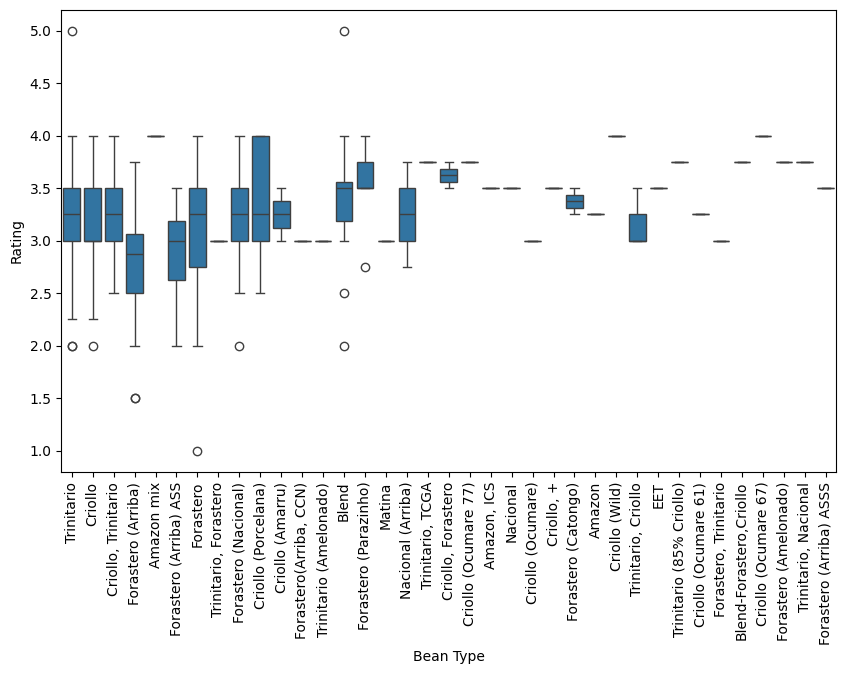

In [ ]:
clean_df = train_df[train_df['Bean Type'] != '\xa0']

plt.figure(figsize=(10, 6))
sns.boxplot(x='Bean Type', y='Rating', data=clean_df)
plt.xticks(rotation=90)
plt.show()

Сгруппируем Bean Type и посмотрим на Rating

In [ ]:
mean_rating_by_type = clean_df.groupby('Bean Type')['Rating'].mean().sort_values()
print(mean_rating_by_type)

Bean Type
Forastero (Arriba)          2.773438
Forastero (Arriba) ASS      2.875000
Matina                      3.000000
Forastero(Arriba, CCN)      3.000000
Trinitario (Amelonado)      3.000000
Criollo (Ocumare)           3.000000
Forastero, Trinitario       3.000000
Trinitario, Forastero       3.000000
Forastero                   3.127358
Trinitario, Criollo         3.166667
Criollo                     3.185096
Forastero (Nacional)        3.191176
Criollo (Amarru)            3.250000
Criollo (Ocumare 61)        3.250000
Nacional (Arriba)           3.250000
Amazon                      3.250000
Trinitario                  3.255263
Criollo, Trinitario         3.257812
Criollo (Porcelana)         3.361111
Forastero (Catongo)         3.375000
Blend                       3.437500
Nacional                    3.500000
EET                         3.500000
Criollo, +                  3.500000
Amazon, ICS                 3.500000
Forastero (Arriba) ASSS     3.500000
Forastero (Parazinho)       

И в конце ANOVA

In [ ]:
from scipy.stats import f_oneway

rating_with_na = train_df[train_df['Bean Type'] == '\xa0']['Rating']
rating_without_na = train_df[train_df['Bean Type'] != '\xa0']['Rating']


f_stat, p_value_anova = f_oneway(rating_with_na, rating_without_na)
print(f"ANOVA: p-value = {p_value_anova}")

ANOVA: p-value = 0.0004254362744941134


Столбец Bean Type важен для целевой переменной.

Посмотрим на корреляции между категориальными и между числовыми признаками

In [ ]:
train_df = train_df.apply(
        lambda x: x.astype("category") if x.dtype == "object" else x)

cramersv = am.CramersV(train_df)

cramersv.fit()

,Company,Specific Bean Origin,Cocoa Percent,Company Location,Bean Type,Broad Bean Origin
Company,1.000000,0.771074,0.631564,0.999651,0.616928,0.603849
Specific Bean Origin,0.771074,1.000000,0.772975,0.808500,0.907954,0.983537
Cocoa Percent,0.631564,0.772975,1.000000,0.243803,0.158700,0.266422
Company Location,0.999651,0.808500,0.243803,1.000000,0.291639,0.383244
Bean Type,0.616928,0.907954,0.158700,0.291639,1.000000,0.388294
Broad Bean Origin,0.603849,0.983537,0.266422,0.383244,0.388294,1.000000


<Axes: >

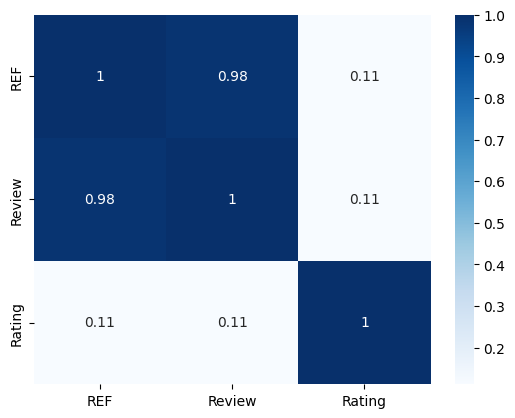

In [ ]:
cols = train_df.select_dtypes(exclude='category').columns

corr = train_df[cols].corr()
sns.heatmap(corr, cmap="Blues", annot=True)

**Очистка данных**

Заменяем пробел в Bean Type на missing, а в Broad Bean Origin на NA

Cocoa Percent лишаем знака % и делаем эту фичу числовой

Убираем Review за ненадобностью (очень высокая корреляция с REF), Specific Bean Origin также убираем, т.к. нет причин оставлять столь информативный столбец: достаточно Broad Bean Origin. В нём же заменяем строки с несколькими странами на Mixed

In [ ]:
def clean_data(df):
  df = df.dropna()
  df['Bean Type'] = df['Bean Type'].replace('\xa0', 'missing')
  df['Broad Bean Origin'] = df['Broad Bean Origin'].replace('\xa0', 'NA')
  df['Broad Bean Origin'] = df['Broad Bean Origin'].apply(
    lambda x: x if x.startswith("St.") or not any(char in x for char in [',', '.', ';']) else 'Mixed'
)
  df['Cocoa Percent'] = df['Cocoa Percent'].str.replace('%', '', regex=False).astype("float64")
  df.drop(['Review', 'Specific Bean Origin'], axis=1, inplace=True)
  df = df.apply(lambda x: x.astype("category") if x.dtype == "object" else x)
  return df

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

In [ ]:
# Заменем временно dtype снова на object, т.к. category хоть и более быстрый, но менее гибкий: он не допускает внесение изменений в категории
train_df = train_df.apply(lambda x: x.astype("object") if x.dtype == "category" else x)

cleaned_train_df = clean_data(train_df)

In [ ]:
X = cleaned_train_df.drop('Rating', axis=1)
y = cleaned_train_df['Rating']

Xtrain, Xval, ytrain, yval = train_test_split(X, y, test_size = .3, random_state=42)

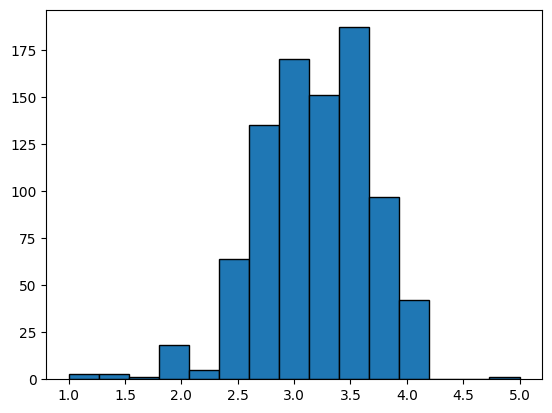

In [ ]:
plt.hist(ytrain, rwidth=1.0, edgecolor='k', bins=15);

In [ ]:
Xtrain.info()

<class 'pandas.core.frame.DataFrame'>
Index: 877 entries, 66 to 1128
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   Company            877 non-null    category
 1   REF                877 non-null    int64   
 2   Cocoa Percent      877 non-null    float64 
 3   Company Location   877 non-null    category
 4   Bean Type          877 non-null    category
 5   Broad Bean Origin  877 non-null    category
dtypes: category(4), float64(1), int64(1)
memory usage: 42.2 KB


Выделим категориальные фичи и визуально проанализируем их

REF


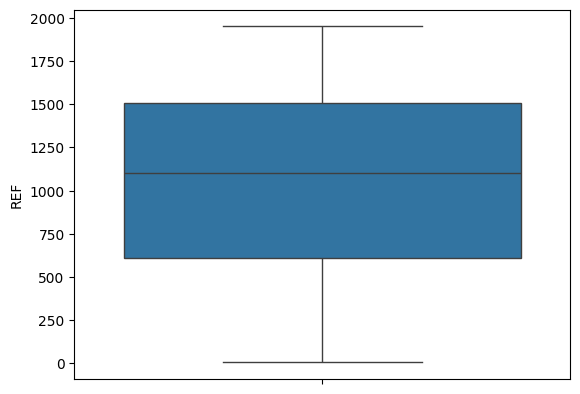

Cocoa Percent


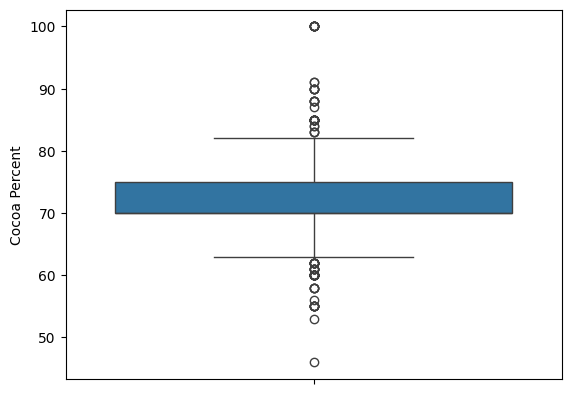

Target


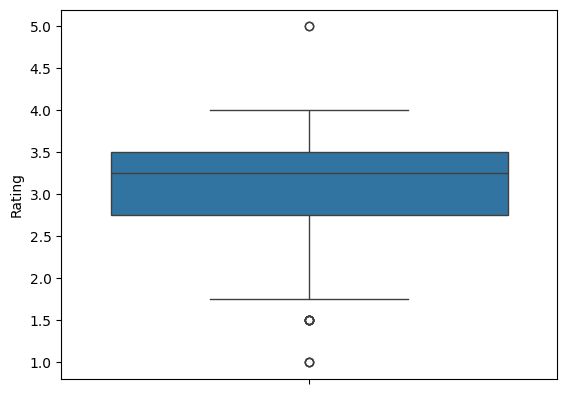

In [ ]:
cat_features = [i for i, col in enumerate(Xtrain.columns) if Xtrain[col].dtype.name in ['category', 'object']]

for col in Xtrain.drop(Xtrain.columns[cat_features], axis=1):
    print(col)
    sns.boxplot(Xtrain[col])
    plt.show()
print('Target')
sns.boxplot(y)
plt.show()

Несмотря на наличие выбросов у ящиков с усами, сами значения выбросов укладываются в возможное распределение

Зайдём с козырей: начнём обучать CatBoostRegressor сначала с гиперпараметрами по умолчанию, а затем начнём их подбор с помощью optuna

In [ ]:
model = CatBoostRegressor(cat_features=cat_features)

In [ ]:
model.fit(Xtrain, ytrain, verbose=False)

In [ ]:
model.score(Xtrain, ytrain)

0.5683524680462445

In [ ]:
pred = model.predict(Xval)

r2_score(yval, pred)

0.10869186293870425

In [ ]:
def objective(trial):
    params = {
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'n_estimators': trial.suggest_int('n_estimators', 10, 1500),
        'max_depth': trial.suggest_int('depth', 2, 16),
        'verbose': 0,
        'early_stopping_rounds': 50
    }
    estimator = CatBoostRegressor(**params, cat_features=cat_features)
    estimator.fit(Xtrain, ytrain, eval_set=(Xval, yval), verbose=False,)
    y_pred = estimator.predict(Xval)
    return r2_score(yval, y_pred)


study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=15)
print(study.best_trial)

[I 2025-02-08 14:28:15,691] A new study created in memory with name: no-name-c9096abb-fb57-4952-b13e-64b7754b31f8
[I 2025-02-08 14:28:20,448] Trial 0 finished with value: 0.13048013374024237 and parameters: {'learning_rate': 0.03110193373369352, 'n_estimators': 588, 'depth': 9}. Best is trial 0 with value: 0.13048013374024237.
[I 2025-02-08 14:29:35,183] Trial 1 finished with value: 0.11146849753611132 and parameters: {'learning_rate': 0.011893937684847053, 'n_estimators': 238, 'depth': 14}. Best is trial 0 with value: 0.13048013374024237.
[I 2025-02-08 14:29:37,106] Trial 2 finished with value: 0.13304952994846542 and parameters: {'learning_rate': 0.208204706149181, 'n_estimators': 697, 'depth': 11}. Best is trial 2 with value: 0.13304952994846542.
[I 2025-02-08 14:30:46,049] Trial 3 finished with value: 0.13089117844234 and parameters: {'learning_rate': 0.013649036401518395, 'n_estimators': 631, 'depth': 13}. Best is trial 2 with value: 0.13304952994846542.
[I 2025-02-08 14:30:49,863

FrozenTrial(number=2, state=1, values=[0.13304952994846542], datetime_start=datetime.datetime(2025, 2, 8, 14, 29, 35, 185048), datetime_complete=datetime.datetime(2025, 2, 8, 14, 29, 37, 106314), params={'learning_rate': 0.208204706149181, 'n_estimators': 697, 'depth': 11}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'learning_rate': FloatDistribution(high=0.3, log=True, low=0.01, step=None), 'n_estimators': IntDistribution(high=1500, log=False, low=10, step=1), 'depth': IntDistribution(high=16, log=False, low=2, step=1)}, trial_id=2, value=None)


In [ ]:
hyper_param_model = CatBoostRegressor(**study.best_params, cat_features=cat_features, verbose=False)
hyper_param_model.fit(Xtrain, ytrain)
new_pred = hyper_param_model.predict(Xval)
r2_score(yval, new_pred)

0.12086663448095858

In [ ]:
hyper_param_model.score(Xtrain, ytrain)

0.5297900016090413

In [ ]:
test_df = pd.read_csv(TEST)

In [ ]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 540 entries, 0 to 539
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Company               540 non-null    object
 1   Specific Bean Origin  540 non-null    object
 2   REF                   540 non-null    int64 
 3   Review                540 non-null    int64 
 4   Cocoa Percent         540 non-null    object
 5   Company Location      540 non-null    object
 6   Bean Type             540 non-null    object
 7   Broad Bean Origin     540 non-null    object
dtypes: int64(2), object(6)
memory usage: 33.9+ KB


In [ ]:
cleaned_test_df = clean_data(test_df)

In [ ]:
pred_test = hyper_param_model.predict(cleaned_test_df)

In [ ]:
cleaned_test_df['id'] = np.arange(len(test_df))
cleaned_test_df['Rating'] = pred_test

cleaned_test_df[['id','Rating']].to_csv("submission2.csv", index=False)